In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from wordcloud import WordCloud
import re
from collections import Counter
import nltk
from nltk.corpus import stopwords

In [5]:
# Set visualization style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

## 1. Data Loading and Initial Exploration

In [9]:
df = load_dataset("nbertagnolli/counsel-chat", cache_dir=".")["train"].to_pandas()

# Display basic information
print(f"Dataset shape: {df.shape}")
print("\nFirst few rows:")
df.head(4)

Repo card metadata block was not found. Setting CardData to empty.


Dataset shape: (2775, 10)

First few rows:


,questionID,questionTitle,questionText,questionLink,topic,therapistInfo,therapistURL,answerText,upvotes,views
0,0,Do I have too many issues for counseling?,I have so many issues to address. I have a his...,https://counselchat.com/questions/do-i-have-to...,depression,Jennifer MolinariHypnotherapist & Licensed Cou...,https://counselchat.com/therapists/jennifer-mo...,It is very common for people to have multiple ...,3,1971
1,0,Do I have too many issues for counseling?,I have so many issues to address. I have a his...,https://counselchat.com/questions/do-i-have-to...,depression,"Jason Lynch, MS, LMHC, LCAC, ADSIndividual & C...",https://counselchat.com/therapists/jason-lynch...,"I've never heard of someone having ""too many i...",2,386
2,0,Do I have too many issues for counseling?,I have so many issues to address. I have a his...,https://counselchat.com/questions/do-i-have-to...,depression,Shakeeta TorresFaith Based Mental Health Couns...,https://counselchat.com/therapists/shakeeta-to...,Absolutely not. I strongly recommending worki...,2,3071
3,0,Do I have too many issues for counseling?,I have so many issues to address. I have a his...,https://counselchat.com/questions/do-i-have-to...,depression,"Noorayne ChevalierMA, RP, CCC, CCAC, LLP (Mich...",https://counselchat.com/therapists/noorayne-ch...,Let me start by saying there are never too man...,2,2643


In [10]:
print("\nDataset info:")
df.info()


Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2775 entries, 0 to 2774
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   questionID     2775 non-null   int64 
 1   questionTitle  2775 non-null   object
 2   questionText   2636 non-null   object
 3   questionLink   2775 non-null   object
 4   topic          2775 non-null   object
 5   therapistInfo  2775 non-null   object
 6   therapistURL   2775 non-null   object
 7   answerText     2749 non-null   object
 8   upvotes        2775 non-null   int64 
 9   views          2775 non-null   int64 
dtypes: int64(3), object(7)
memory usage: 216.9+ KB


In [11]:
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df) * 100).round(2)

missing_df = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percent
})
print("\nMissing values summary:")
print(missing_df)


Missing values summary:
               Missing Values  Percentage
questionID                  0        0.00
questionTitle               0        0.00
questionText              139        5.01
questionLink                0        0.00
topic                       0        0.00
therapistInfo               0        0.00
therapistURL                0        0.00
answerText                 26        0.94
upvotes                     0        0.00
views                       0        0.00


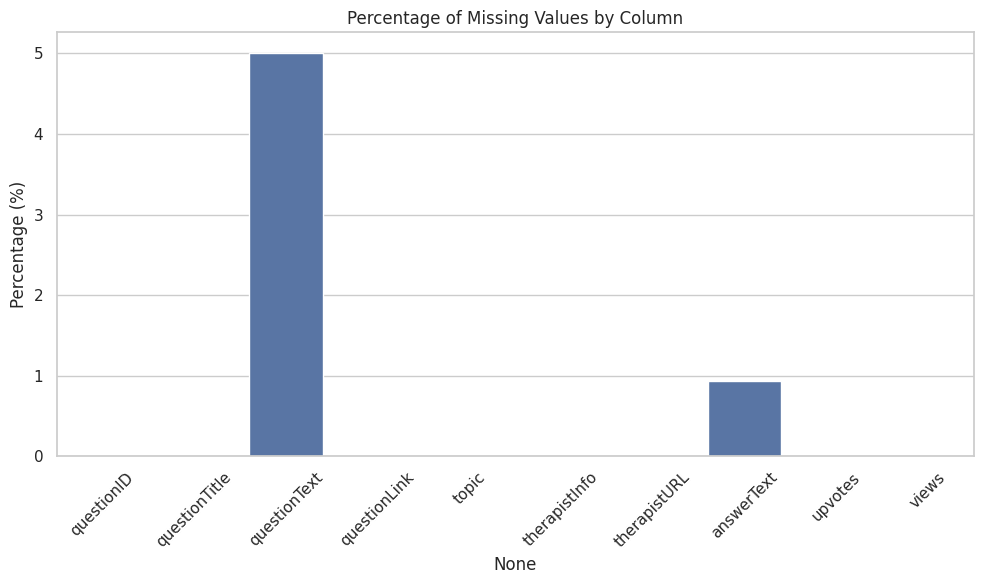

In [12]:
plt.figure(figsize=(10, 6))
sns.barplot(x=missing_df.index, y='Percentage', data=missing_df)
plt.title('Percentage of Missing Values by Column')
plt.xticks(rotation=45)
plt.ylabel('Percentage (%)')
plt.tight_layout()
plt.show()

## 2. Data Cleaning and Preprocessing

In [15]:
df_clean = df.dropna(subset=['questionText', 'answerText']).copy()
df_clean['question_len'] = df_clean['questionText'].str.len()
df_clean['answer_len'] = df_clean['answerText'].str.len()
df_clean['title_len'] = df_clean['questionTitle'].str.len()

print(f"Original dataset: {df.shape[0]} rows")
print(f"Clean dataset: {df_clean.shape[0]} rows")
print(f"Removed {df.shape[0] - df_clean.shape[0]} rows with missing question or answer text")

Original dataset: 2775 rows
Clean dataset: 2612 rows
Removed 163 rows with missing question or answer text


In [16]:
question_counts = df.groupby('questionID').size().reset_index(name='answer_count')
print(f"Total unique questions: {len(question_counts)}")
print(f"Average answers per question: {question_counts['answer_count'].mean():.2f}")

Total unique questions: 940
Average answers per question: 2.95


## 3. Topic Distribution Analysis


Topic distribution:
topic
depression                  465
anxiety                     358
counseling-fundamentals     270
intimacy                    248
relationships               202
parenting                   191
family-conflict             144
trauma                      102
self-esteem                 100
relationship-dissolution     98
Name: count, dtype: int64


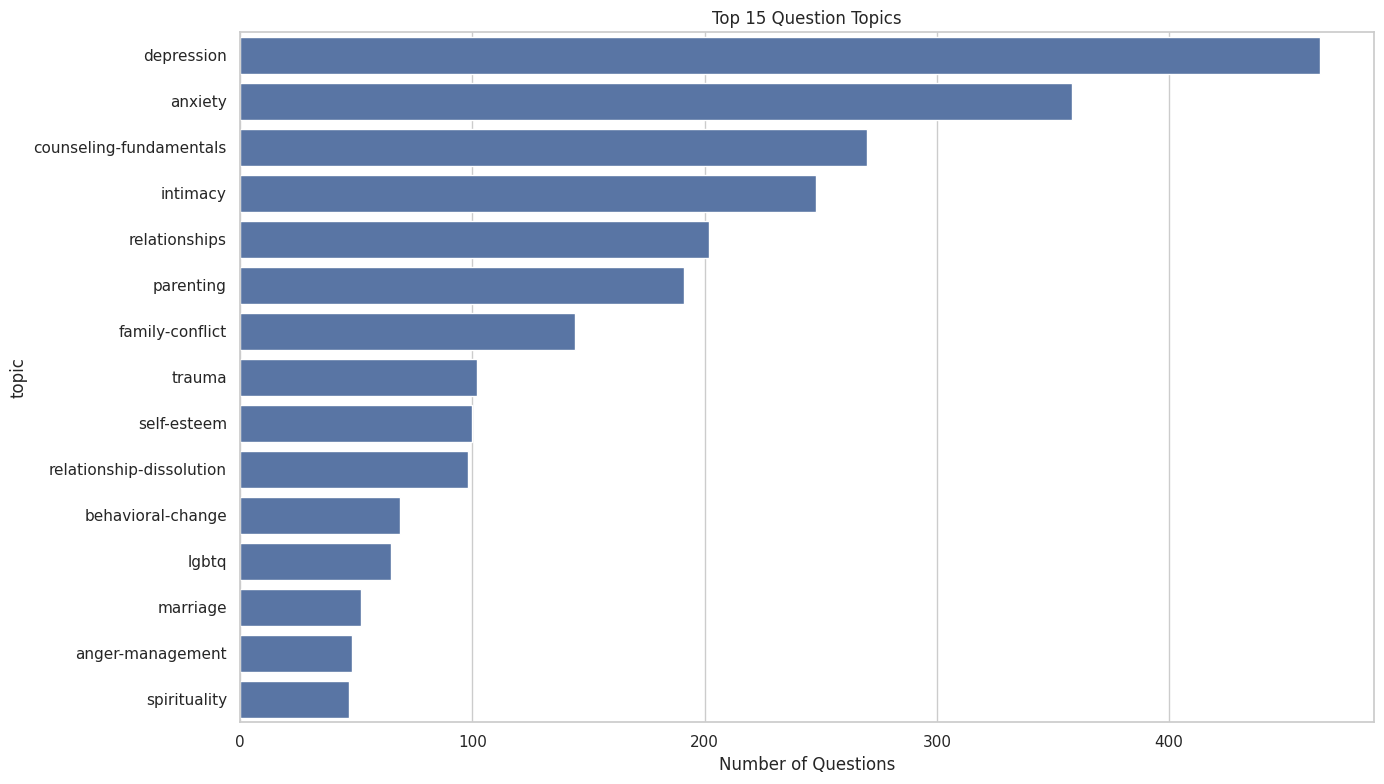

In [19]:
topic_counts = df['topic'].value_counts()
print("\nTopic distribution:")
print(topic_counts.head(10))

plt.figure(figsize=(14, 8))
sns.barplot(x=topic_counts.values[:15], y=topic_counts.index[:15])
plt.title('Top 15 Question Topics')
plt.xlabel('Number of Questions')
plt.tight_layout()
plt.show()


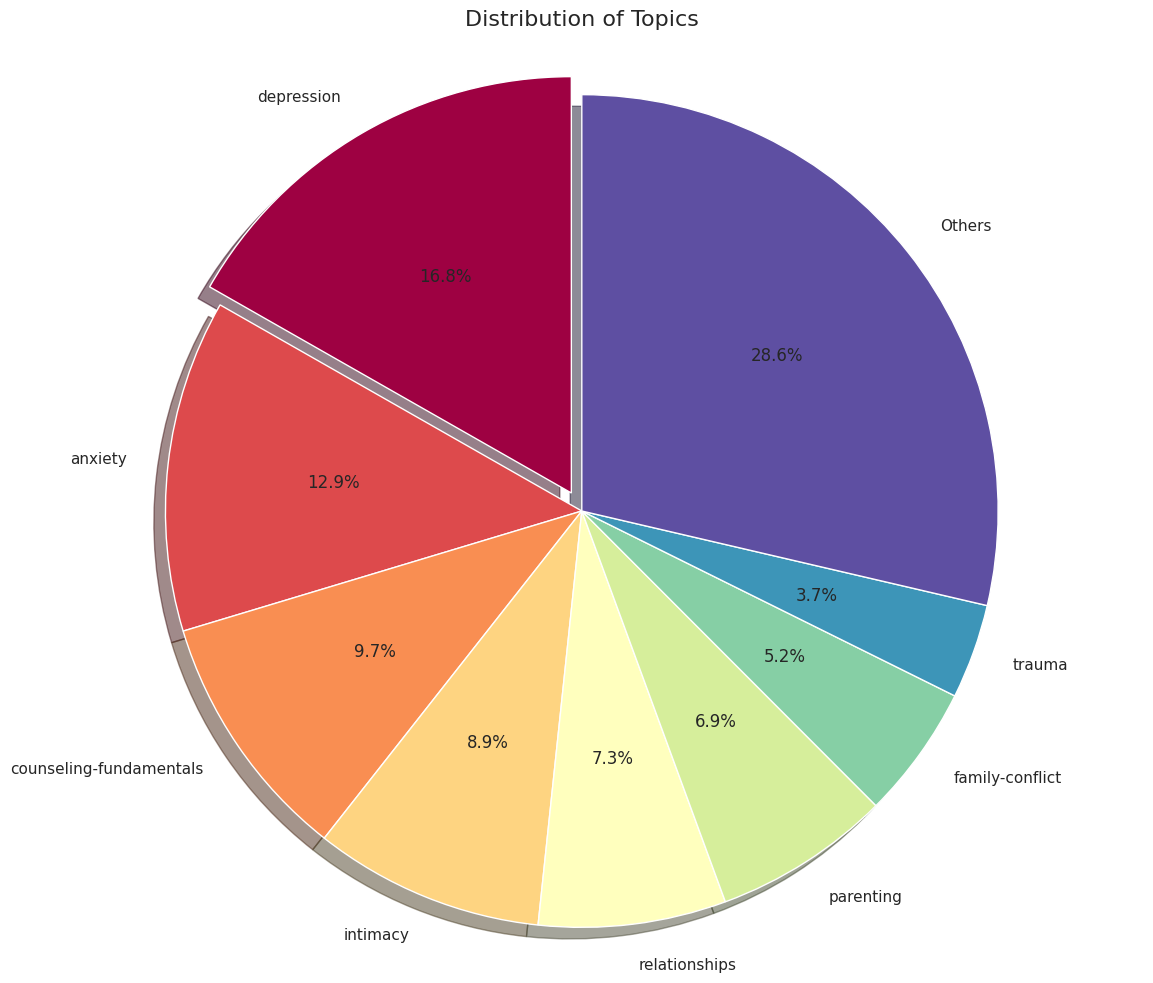

In [20]:
top_n = 8
top_topics = topic_counts.head(top_n)
other_topics = pd.Series({'Others': topic_counts[top_n:].sum()})
pie_data = pd.concat([top_topics, other_topics])

plt.figure(figsize=(12, 10))
plt.pie(pie_data, labels=pie_data.index, autopct='%1.1f%%', startangle=90, shadow=True, 
        explode=[0.05] + [0] * (len(pie_data) - 1), 
        colors=plt.cm.Spectral(np.linspace(0, 1, len(pie_data))))
plt.title('Distribution of Topics', fontsize=16)
plt.axis('equal')
plt.tight_layout()
plt.show()

## 4. Text Length Analysis

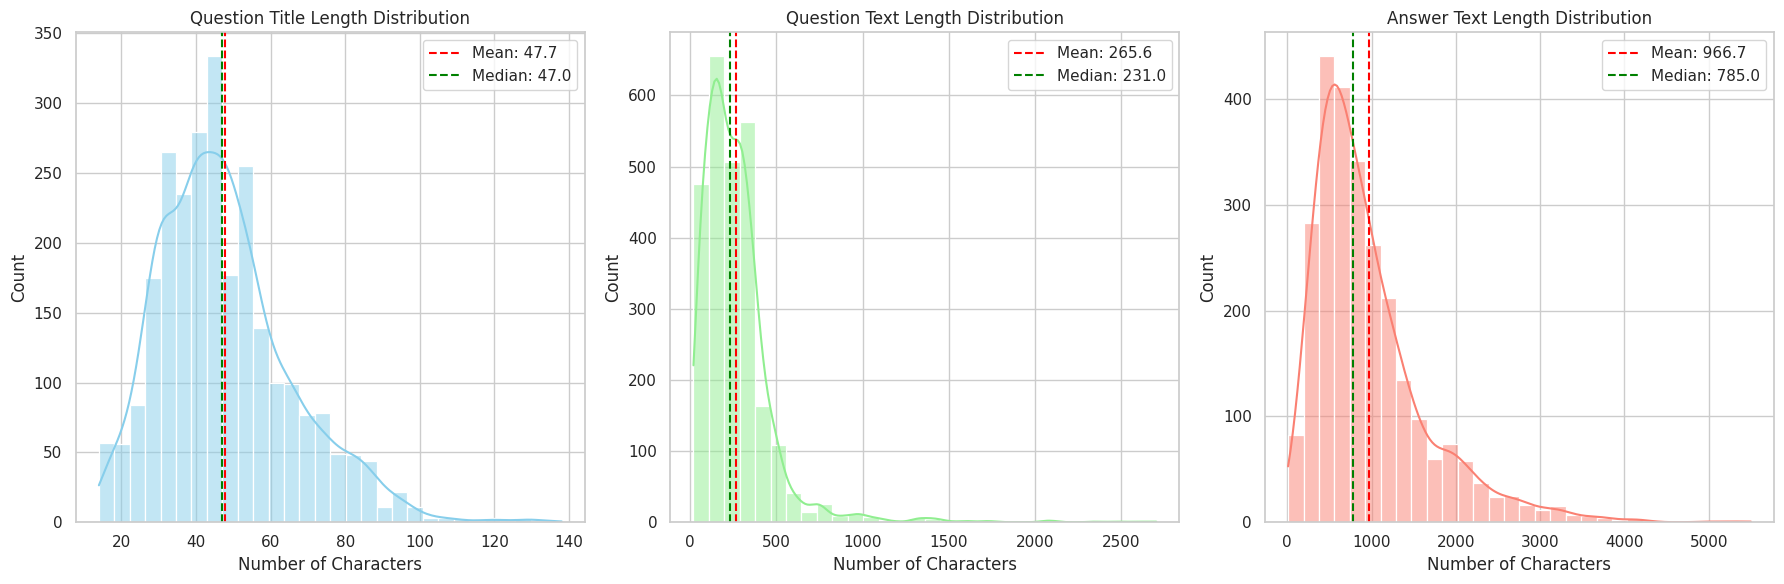

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Question Title Length
sns.histplot(df_clean['title_len'], kde=True, bins=30, ax=axes[0], color='skyblue')
axes[0].set_title('Question Title Length Distribution')
axes[0].set_xlabel('Number of Characters')
axes[0].axvline(df_clean['title_len'].mean(), color='red', linestyle='--', 
                label=f'Mean: {df_clean["title_len"].mean():.1f}')
axes[0].axvline(df_clean['title_len'].median(), color='green', linestyle='--', 
                label=f'Median: {df_clean["title_len"].median():.1f}')
axes[0].legend()

# Question Text Length
sns.histplot(df_clean['question_len'], kde=True, bins=30, ax=axes[1], color='lightgreen')
axes[1].set_title('Question Text Length Distribution')
axes[1].set_xlabel('Number of Characters')
axes[1].axvline(df_clean['question_len'].mean(), color='red', linestyle='--', 
                label=f'Mean: {df_clean["question_len"].mean():.1f}')
axes[1].axvline(df_clean['question_len'].median(), color='green', linestyle='--', 
                label=f'Median: {df_clean["question_len"].median():.1f}')
axes[1].legend()

# Answer Text Length
sns.histplot(df_clean['answer_len'], kde=True, bins=30, ax=axes[2], color='salmon')
axes[2].set_title('Answer Text Length Distribution')
axes[2].set_xlabel('Number of Characters')
axes[2].axvline(df_clean['answer_len'].mean(), color='red', linestyle='--', 
                label=f'Mean: {df_clean["answer_len"].mean():.1f}')
axes[2].axvline(df_clean['answer_len'].median(), color='green', linestyle='--', 
                label=f'Median: {df_clean["answer_len"].median():.1f}')
axes[2].legend()

plt.tight_layout()
plt.show()


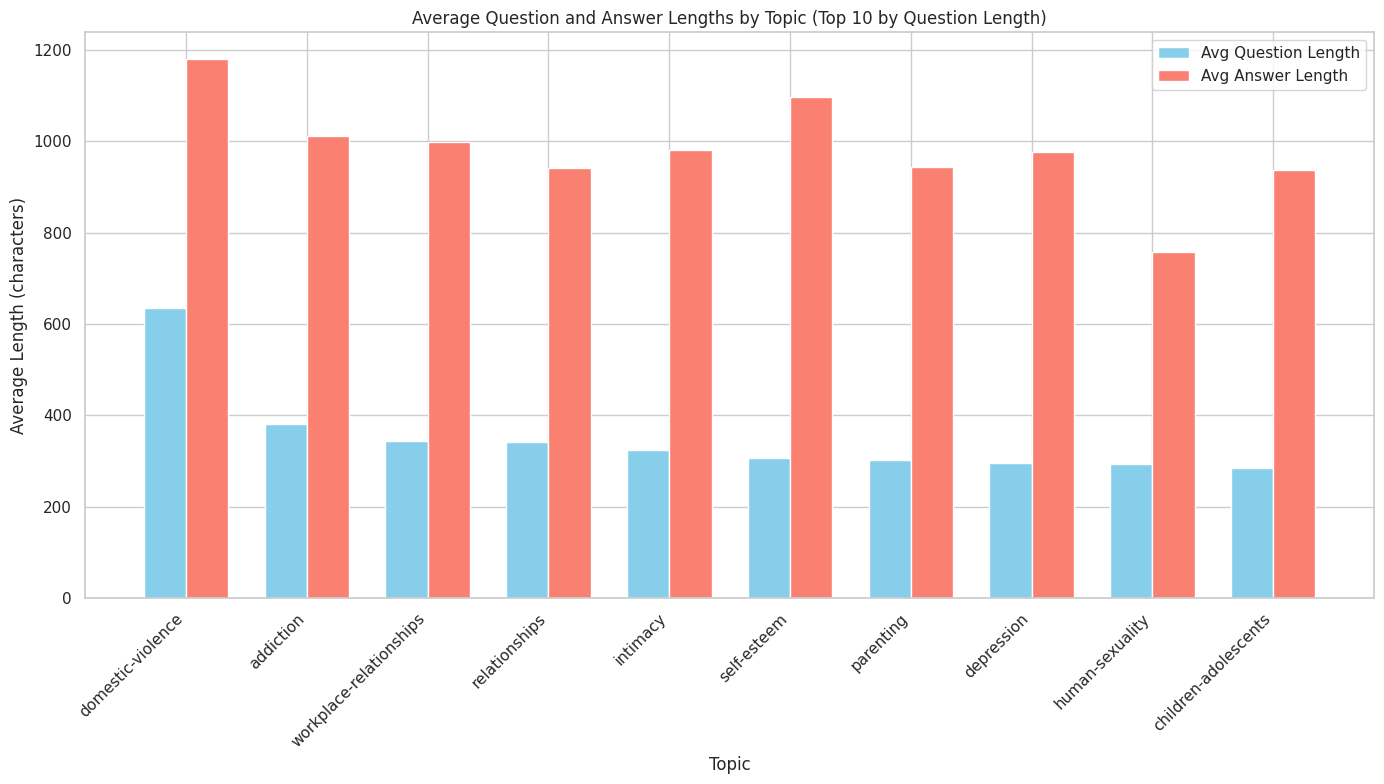

In [22]:
# Text length statistics by topic 
topic_text_stats = df_clean.groupby('topic').agg({
    'question_len': ['mean', 'median'],
    'answer_len': ['mean', 'median']
}).sort_values(('question_len', 'mean'), ascending=False)


topic_text_stats.columns = ['question_len_mean', 'question_len_median', 'answer_len_mean', 'answer_len_median']
topic_text_stats = topic_text_stats.reset_index()

plt.figure(figsize=(14, 8))
top10_topics = topic_text_stats.head(10)

x = np.arange(len(top10_topics))
width = 0.35

plt.bar(x - width/2, top10_topics['question_len_mean'], width, label='Avg Question Length', color='skyblue')
plt.bar(x + width/2, top10_topics['answer_len_mean'], width, label='Avg Answer Length', color='salmon')

plt.xlabel('Topic')
plt.ylabel('Average Length (characters)')
plt.title('Average Question and Answer Lengths by Topic (Top 10 by Question Length)')
plt.xticks(x, top10_topics['topic'], rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

## 5. Engagement Analysis (Upvotes and Views)

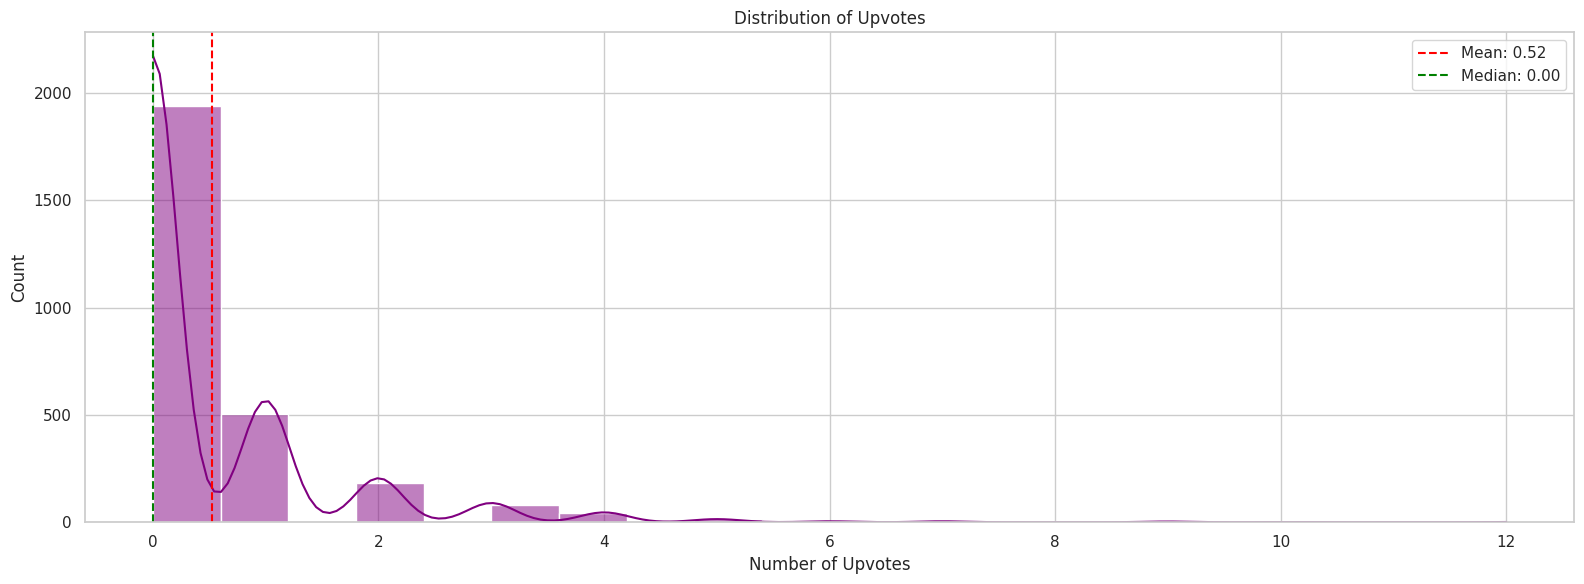

In [ ]:
# Distribution of upvotes
fig, axes = plt.subplots(1, 1, figsize=(16, 6))

# Upvotes distribution
sns.histplot(df['upvotes'], kde=True, bins=20, ax=axes, color='purple')
axes.set_title('Distribution of Upvotes')
axes.set_xlabel('Number of Upvotes')
axes.axvline(df['upvotes'].mean(), color='red', linestyle='--', 
                label=f'Mean: {df["upvotes"].mean():.2f}')
axes.axvline(df['upvotes'].median(), color='green', linestyle='--', 
                label=f'Median: {df["upvotes"].median():.2f}')
axes.legend()

plt.tight_layout()
plt.show()

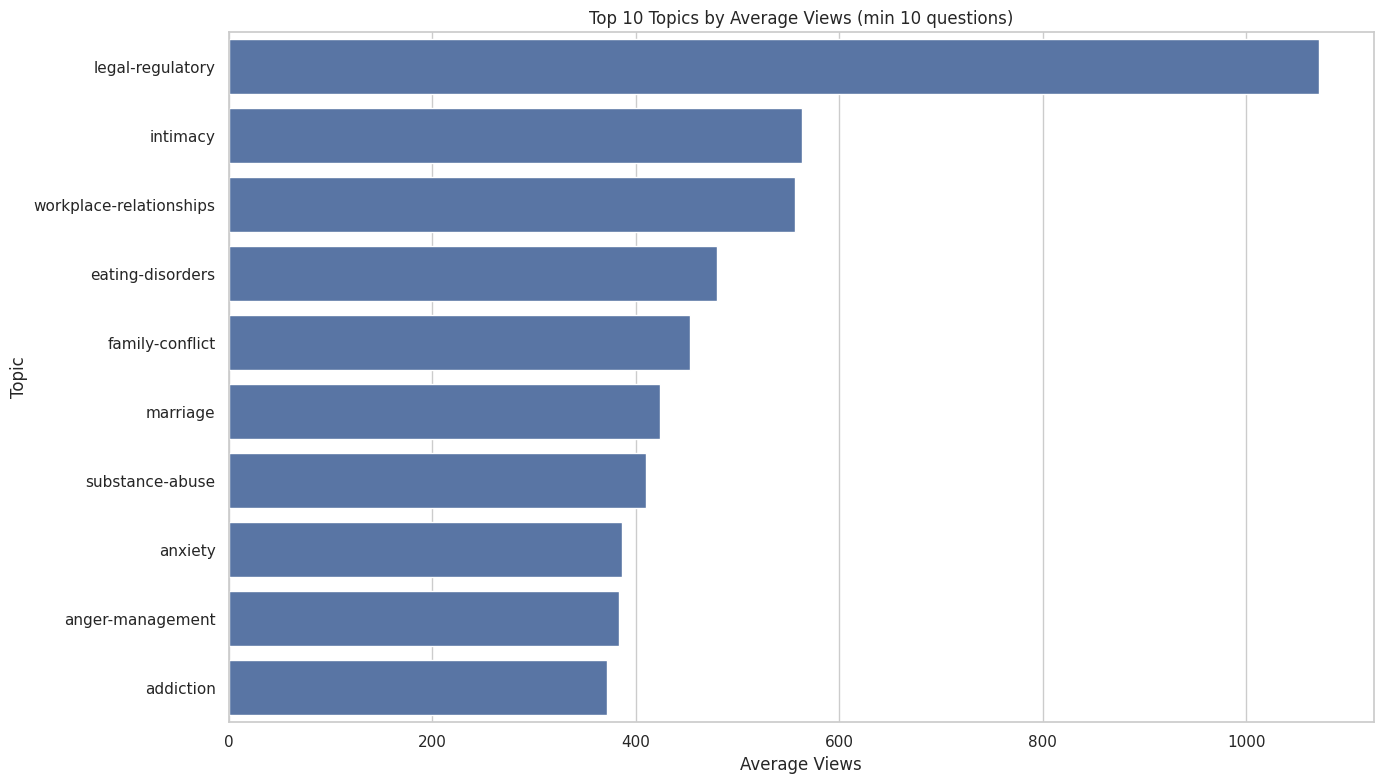

In [32]:
# Average engagement by topic
topic_engagement = df.groupby('topic').agg({
    'views': ['mean', 'count'],
    'upvotes': ['mean', 'sum']
}).sort_values(('views', 'mean'), ascending=False)


topic_engagement.columns = ['views_mean', 'question_count', 'upvotes_mean', 'total_upvotes']
topic_engagement = topic_engagement.reset_index()

# Filter topics with at least 10 questions
topic_engagement_filtered = topic_engagement[topic_engagement['question_count'] >= 10]

# Plot of top 10 topics by average views
plt.figure(figsize=(14, 8))
top10_by_views = topic_engagement_filtered.sort_values('views_mean', ascending=False).head(10)

sns.barplot(x='views_mean', y='topic', data=top10_by_views)
plt.title('Top 10 Topics by Average Views (min 10 questions)')
plt.xlabel('Average Views')
plt.ylabel('Topic')
plt.tight_layout()
plt.show()

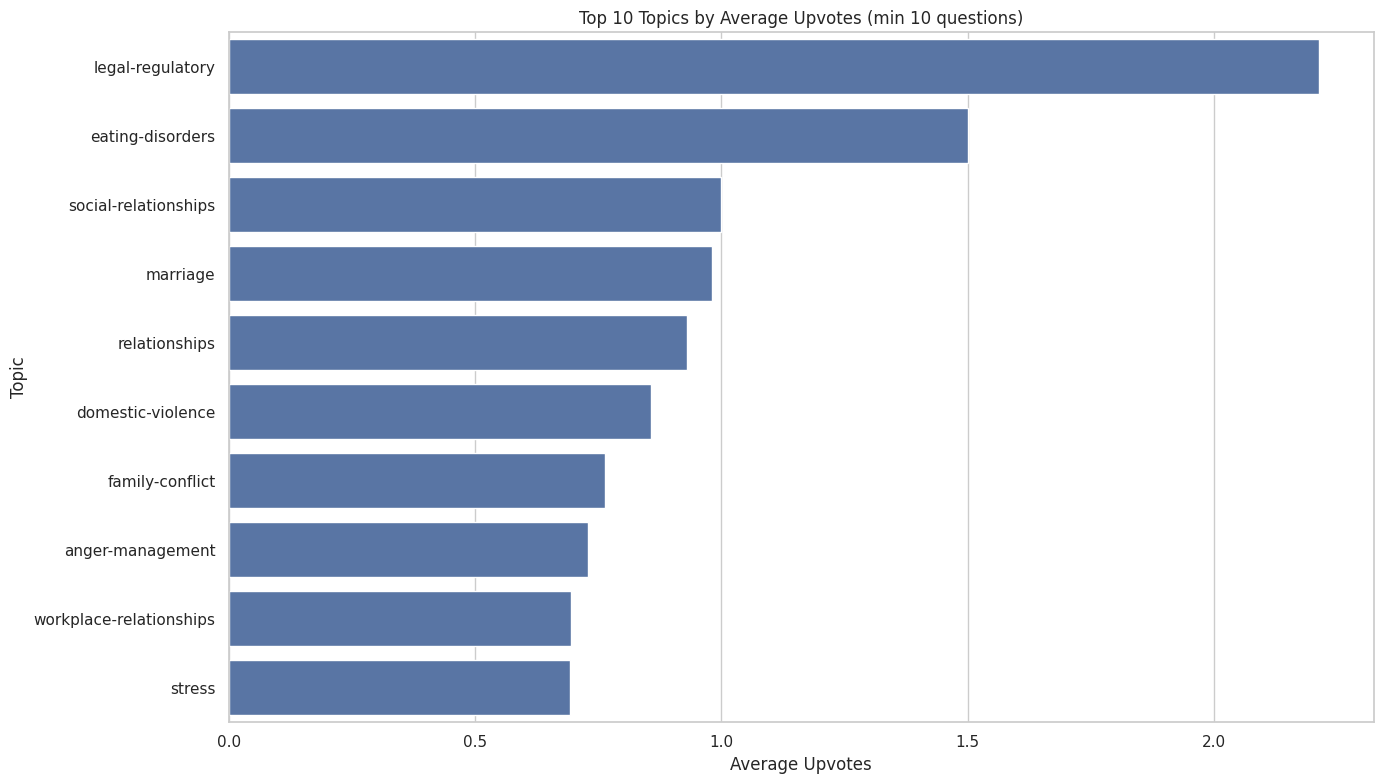

In [31]:
# Plot top 10 topics by average upvotes
plt.figure(figsize=(14, 8))
top10_by_upvotes = topic_engagement_filtered.sort_values('upvotes_mean', ascending=False).head(10)

sns.barplot(x='upvotes_mean', y='topic', data=top10_by_upvotes)
plt.title('Top 10 Topics by Average Upvotes (min 10 questions)')
plt.xlabel('Average Upvotes')
plt.ylabel('Topic')
plt.tight_layout()
plt.show()

## 6. Correlation Analysis

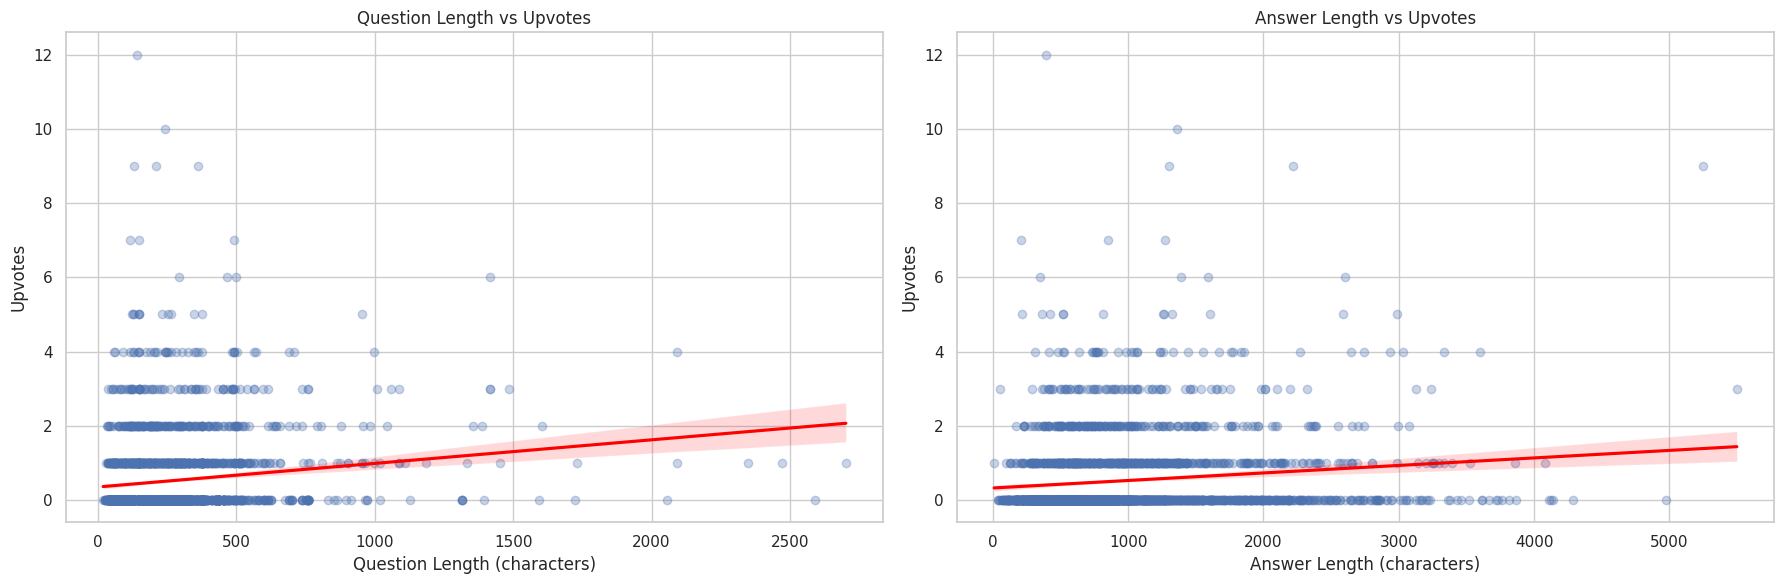

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))  # 1 row, 2 columns

# Question length vs upvotes
sns.regplot(
    x='question_len', y='upvotes', data=df_clean,
    scatter_kws={'alpha':0.3}, line_kws={'color':'red'}, ax=axes[0]
)
axes[0].set_title('Question Length vs Upvotes')
axes[0].set_xlabel('Question Length (characters)')
axes[0].set_ylabel('Upvotes')

# Answer length vs upvotes
sns.regplot(
    x='answer_len', y='upvotes', data=df_clean,
    scatter_kws={'alpha':0.3}, line_kws={'color':'red'}, ax=axes[1]
)
axes[1].set_title('Answer Length vs Upvotes')
axes[1].set_xlabel('Answer Length (characters)')
axes[1].set_ylabel('Upvotes')

plt.tight_layout()
plt.show()

## 7. Text Content Analysis with Word Clouds

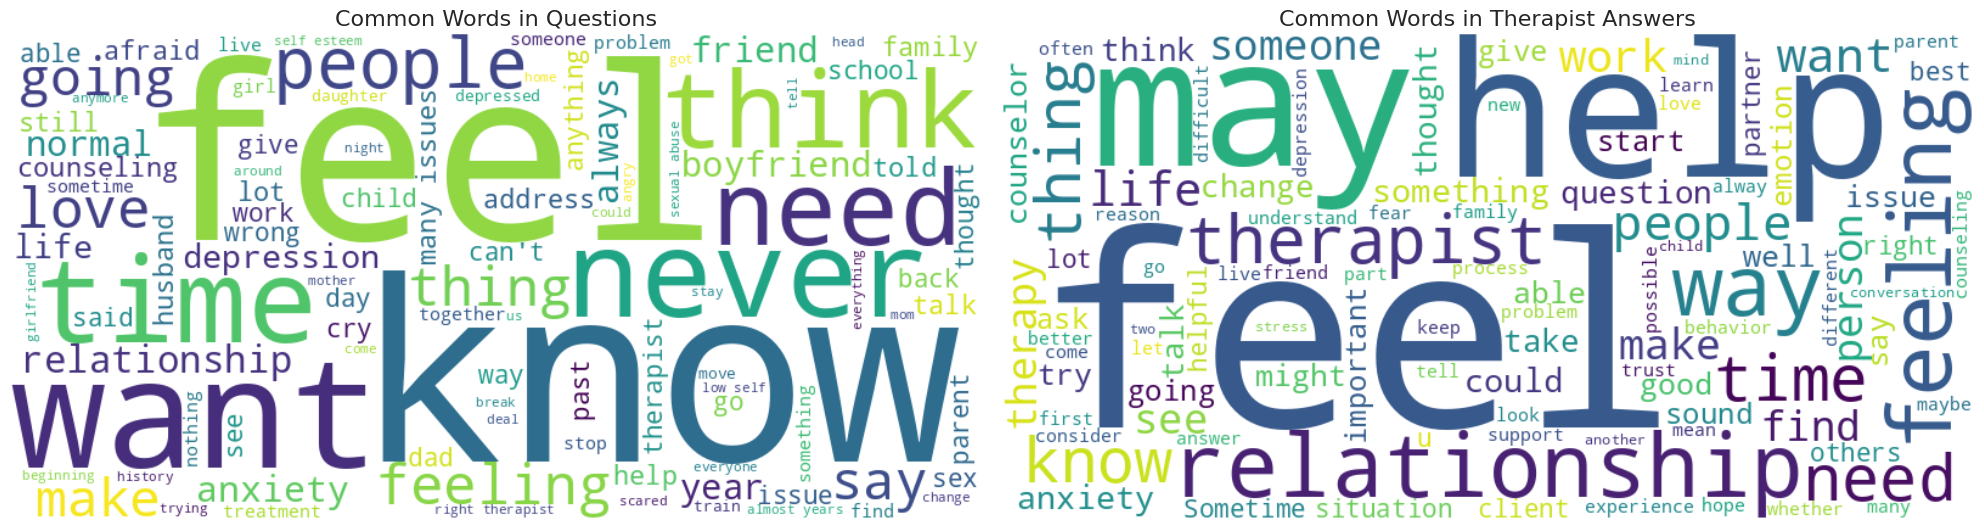

In [38]:
def create_wordcloud_ax(texts, title, stopwords, ax):
    all_text = " ".join(texts)
    wordcloud = WordCloud(
        width=800, height=400, background_color='white', 
        max_words=100, contour_width=3, contour_color='steelblue',
        stopwords=stopwords
    ).generate(all_text)

    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(title, fontsize=16)
    ax.axis("off")

# Getting and removing common stopwords
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
custom_stopwords = {'like', 'im', 'ive', 'just', 'dont', 'get', 'one', 'really', 'also', 'even', 'much', 'would'}
all_stopwords = stop_words.union(custom_stopwords)


fig, axes = plt.subplots(1, 2, figsize=(20, 10))  # 1 row, 2 columns

# Word cloud for questions
create_wordcloud_ax(df_clean['questionText'].dropna(), 'Common Words in Questions', all_stopwords, axes[0])

# Word cloud for answers
create_wordcloud_ax(df_clean['answerText'].dropna(), 'Common Words in Therapist Answers', all_stopwords, axes[1])

plt.tight_layout()
plt.show()

# Training the Model